# Molybdenum doped Vanadium Dioxide Data

We will be comparing the result of standard punch and fill to that of the technique involving watershed segmentation of the Bragg peaks followed by Laplacian and Matern fill. 

The data can be found on nxrs:
`/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs`

From Matt: the most relevant scattering is found half-integer L planes, with only weak size-effect scattering close to the Bragg peaks; a 3D-deltaPDF should show a clear 2D 'X' pattern.

In [1]:
# Set up directories for {Charlotte,Vishwas}'s machine.
#The repo_dir and base_dir is customized for Charlotte's and Vishwas' laptops.
#It needs to be changed appropriately for other machines. repo_dir corresponds to
#the directory where the git repo 'laplaceinterpolation' is saved.
from   pathlib import Path
import socket
home = str(Path.home())
hostname = str(socket.gethostname())

# If not Charlotte's home, Vishwas's home
if home == '/Users/charlottehaley':
    base_dir = home + '/Documents/Data/Xray/md_54_4b/'
    repo_dir = home + '/Documents/Repos/LaplaceInterpolation.jl/'
if home == '/Users/vishwasrao':
    base_dir = home +'/Research/BES_Project/Data/'
    #repo_dir = home + '/Research/BES_Project/Repo/LaplaceInterpolation.jl/'
    repo_dir = home + '/Github/LaplaceInterpolation.jl/'

save_data_dir = base_dir

# filename and filename_background customized to work on Charlotte's and Vishwas's laptops and on nxrs.
# For other machines, may need some edits.
if "nxrs" in hostname and "nxrs0" not in hostname:
    filename = '/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_120K.nxs'
    filename_background = '/data3/GUP-53547/movo2_40/md_54_4b/movo2_40_background.nxs'
    save_data_dir = home
else:
    filename = base_dir + 'movo2_40_120K.nxs'
    filename_background = base_dir + 'movo2_40_background.nxs'

In [2]:
# loads libraries and functions that are usually used
# functions included: flipaxis, getbraggs, getstencil, peel, 
# standard_punch
import sys
sys.path.insert(1, repo_dir)

import numpy as np
import matplotlib.pyplot as plt
from   scipy.interpolate import Rbf
from   nexusformat.nexus import *
from scipy.interpolate import RBFInterpolator

import scipy.signal
from   astropy.convolution import convolve, Kernel, Gaussian1DKernel
import math
import scipy.ndimage

from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton

import math, timeit

# This may work differently for you on the server, note that julia v 1.5.4 should be used (v 1.6.0 is incompatible)
from julia import Julia
julia = Julia(compiled_modules=False)
from julia import Main
# This line requires that https://bitbucket.org/vishwasrao/LaplaceInterpolation.jl be added to 
# your julia installation (>julia using Pkg; Pkg.add("https://bitbucket.org/vishwasrao/LaplaceInterpolation.jl"))
from julia import LaplaceInterpolation
#julia.include(repo_dir+"/MaternKernelApproximation.jl")

def flipaxis(A,i):
    Aprime=np.swapaxes(np.swapaxes(A,0,i)[::-1],0,i)
    return Aprime

In [3]:
# Load data, print tree.
data = nxload(filename)
data.unlock()

movo2_40_background = nxload(filename_background)
movo2_40_background.unlock()

#print(data.tree)

## Generate the symmetric transform data

In [4]:
z3d = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxvalue 
# - movo2_40_background.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].data.nxdata Extending the data to
# 6.2, 8.2, 8.2 for convenience during the interpolation step.

## Initialize X, Y, Z and dX, dY, and dZ

In [5]:
# The markers should be the Bragg locations
x = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Ql.nxvalue
x2 = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Qk.nxvalue
x3 = data.entry.symm_transform[-0.2:6.2,-0.2:8.2,-0.2:8.2].Qh.nxvalue

dx = x[1] - x[0]
dx2 = x2[1] - x2[0]
dx3 = x3[1] - x3[0]

## Define the symmetrizing operation and the standard punch

In [6]:
Qh_lim=8
Qk_lim=8
Ql_lim=6

kmin=50*(6-Ql_lim)
kmax=50*(6+Ql_lim)
jmin=50*(8-Qk_lim)
jmax=50*(8+Qk_lim)
imin=50*(8-Qh_lim)
imax=50*(8+Qh_lim)

def symmetrize(res):
    # Convolultion happens over a single octant of the dataset
    # This is a bit ad-hoc as the indices are hard-coded.
    vvals=np.zeros((601,801,801))
    vvals[290:601,390:801,390:801] = res
    vvals[300:601,400:801,0:401] = flipaxis(vvals[300:601,400:801,400:801],2)
    vvals[300:601,0:401,0:801] = flipaxis(vvals[300:601,400:801,0:801],1)
    vvals[0:301,0:801,0:801] = flipaxis(vvals[300:601,0:801,0:801],0)
    # background subtraction - what is the minimum spherically symmetric background - not
    # rigorously based on anything
    # vvals=vvals[kmin:kmax,jmin:jmax,imin:imax]-movo2_40_background.entry.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].data.nxdata-2
    # Anything less than zero is set to zero. No intensity should be less than zero
    # vvals[vvals < 0] = 0
    return vvals[0:600,0:800,0:800]

In [7]:
# Matern Interpolation happens here. 
epsilon = 0.0 # Regularization parameter
m = 2 # Matern parameter
#radius = 0.0 # Punch radius
radius = 0.2
h = 0.02 # approximate grid spacing. For MoVO2, the grid spacing along all directions are the same.
#For other Crystals, this might not be so. In that case, we have separate values of h,k,l.
# including the boundaries to see how things work
xmin = 0
xmax = 7
ymin = 0
ymax = 9
zmin = 0
zmax = 9
xbegin = ybegin = zbegin = -0.2
z3d_copy = np.copy(z3d) #Creating a copy to ensure the original is not overwritten.
z3d_punched = np.copy(z3d)
z3d_restored = np.copy(z3d) #Creating a copy to ensure the original is not overwritten.
stride = 10 # This is used to send chunks of the volume data for processing.
#Interpolating across entire data can be time consuming. Instead, dividing into small chunks
#results in smaller but a large number of linear systems. Currently, "stride" is chosen adhoc. 
#For MoVO2, I chose 10 to ensure that the length of the cube of the data that is sent is slightly
#larger than the diameter of the punch. In case of Matern, different "stride" values will result 
#in different interpolation results.  Larger stride values might result in "better" interpolation
#but this comes at a cost. For Laplace, however, interpolation results are independent of the value
#of stride as long as length of the cube of the data that is sent is slightly larger than the
#diameter of the punch. In summary, value of "stride" depends somewhat on the problem. 

In [27]:
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i - zbegin) / h) - stride #(i2-i1)*h will be the length of the cube
    
    i2 = i1 + 2 * stride + 1 #Here we are sending only the cube surrounding the punch
    
    #for interpolation.
    #print(i1,i2)
    for j in range(ymin, ymax):
        j1 = int((j - ybegin) / h) - stride
        j2 = j1 + 2 * stride + 1 #(j2-j1)*h will be the length of the cube. For some crystals
        # (j2-j1)*h != (i2-i1)*h because of different aspect ratios.
        
       
        for k in range(xmin, xmax):
            k1 = int((k - xbegin) / h) - stride
            k2 = k1 + 2 * stride + 1 #(k2-k1)*h will be the length of the cube. 
            z3temp = z3d_copy[k1:k2, j1:j2, i1:i2] #Instead of sending the entire z3d, We are just sending a 
    #small section of it for interpolation.
            absolute_indices = LaplaceInterpolation.punch_3D_cart([k,j,i], radius, x[k1:k2], x2[j1:j2], x3[i1:i2])
            restored_img = LaplaceInterpolation.matern_3d_grid(z3temp, absolute_indices,
                                                              m, epsilon, h, h, h) #h=k=l here
#             print(np.shape(restored_img))
            #punched_image_reshape =  np.reshape(punched_image, (2 * stride + 1, 2 * stride + 1, 2 * stride + 1))
            #z3d_punched[k1:k2, j1:j2, i1:i2] = punched_image_reshape.T
            #restored_img_reshape = np.reshape(restored_img, (2 * stride + 1, 2 * stride + 1, 2 * stride + 1))
            z3d_restored[k1:k2, j1:j2, i1:i2] = restored_img #Image needs to be transposed because
            #of a different ordering in Julia
            
            
print("Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)

# The result of the Matern interpolation is in z3d_restored

Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2: 164.18428997799992


In [26]:
idx = 300
starttime = timeit.default_timer()
restored_img, punched_image = LaplaceInterpolation.Matern3D_Grid(x[0:idx], x2[0:idx], x3[0:idx], z3d_copy[0:idx,0:idx,0:idx],
                                                              epsilon, radius, h, h, h, m)
restored_img_reshape = np.reshape(restored_img, (idx, idx, idx))
restored_img_full = restored_img_reshape.T
print("Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2:", 
      timeit.default_timer() - starttime)

Time taken for Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2: 116.65025055100023


In [27]:
# Do the parallel part in julia
starttime = timeit.default_timer()
restored = LaplaceInterpolation.Parallel_Matern3D_Grid(x, x2, x3, z3d, epsilon, radius,
                                 h, h, h, 0.0, 6.0, 0.0, 8.0, 0.0, 8.0, m)
parallel_matern_restored = np.reshape(restored, (len(x2), len(x3), len(x)))
parallel_matern_restored = parallel_matern_restored.T
print("Time taken for parallel Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)

Time taken for parallel Matern interpolation with m = 2 and epsilon = 0, punch radius 0.2: 97.81363784899986


In [28]:
starttime = timeit.default_timer()
restored = LaplaceInterpolation.Parallel_Laplace3D_Grid(x, x2, x3, z3d, radius,
                                 h, h, h, 0.0, 6.0, 0.0, 8.0, 0.0, 8.0)

parallel_laplace_restored = np.reshape(restored, (len(x2), len(x3), len(x)))
parallel_laplace_restored = parallel_laplace_restored.T
print("Time taken for parallel Laplace interpolation with m = 1 and epsilon = 0, punch radius 0.2:", timeit.default_timer() - starttime)


Time taken for parallel Laplace interpolation with m = 1 and epsilon = 0, punch radius 0.2: 36.43931168500012


In [ ]:
# Laplace interpolation happens here.
# Interpolated data is in z3d_restored_laplace. Original in z3d.

z3d_copy = np.copy(z3d)
z3d_restored_laplace = np.copy(z3d)
starttime = timeit.default_timer()
for i in range(zmin, zmax):
    i1 = int((i - zbegin) / h) - stride #Please see the comments in the Matern interpolation cell.
    i2 = i1 + 2 * stride + 1
    for j in range(ymin, ymax):
        j1 = int((j - ybegin) / h) - stride
        j2 = j1 + 2 * stride + 1
        for k in range(xmin, xmax):
            k1 = int((k - ybegin) / h) - stride
            k2 = k1 + 2 * stride + 1
            z3temp = z3d_copy[k1:k2, j1:j2, i1:i2] #Instead of sending the entire z3d, We are just passing a 
    #small section of it for interpolation.
            restored_img, punched_image = LaplaceInterpolation.Matern3D_Grid(x[k1:k2], x2[j1:j2], x3[i1:i2], z3temp, epsilon, radius, h,
                                                              h, h, m)
            restored_img_reshape = np.reshape(restored_img, (2 * stride + 1, 2 * stride + 1, 2 * stride + 1))
            z3d_restored_laplace[k1:k2, j1:j2, i1:i2] = restored_img_reshape.T
            
            
print("Time taken for Laplace interpolation with punch radius 0.2:", timeit.default_timer() - starttime)

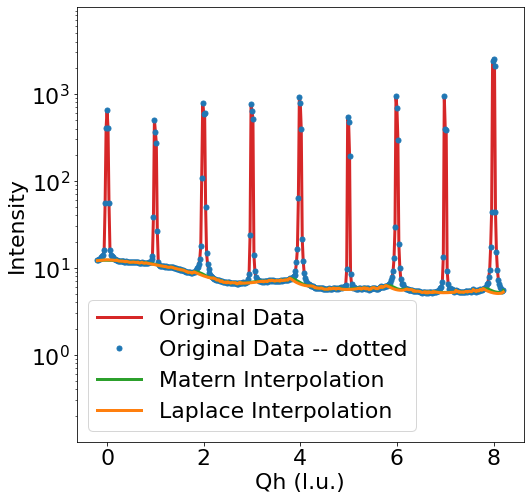

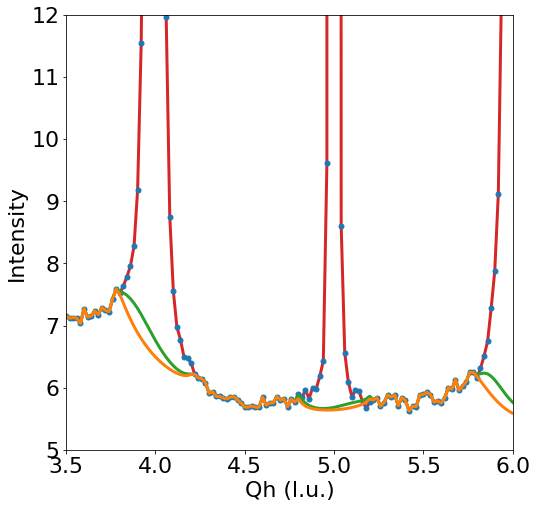

In [30]:
# Taking a 1D slice

# Index in x and y
idx = 60
idy = 60

# Find the maximum of the data on the slice common to both z3d_copy and z3d (are these different?) and add 10 for good measure
max1 = np.max(z3d_copy[idy,idx,:])
max2 = np.max(z3d[idy,idx,:])
max_y = np.max([max1, max2])+10

# Plot original data, matern and laplace interpolations
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)
plt.figure(figsize=(8, 8))
plt.semilogy(x3, (z3d[idy, idx, :]), 'tab:red', lw=3)
plt.semilogy(x3, (z3d[idy, idx, :]), 'o', markersize=5, color='tab:blue')
plt.semilogy(x3, (z3d_restored[idy, idx, :]), lw=3, color='tab:green')
plt.semilogy(x3, (parallel_laplace_restored[idy, idx, :]), lw=3, color='tab:orange')
plt.ylim(1e-1, 1e4)
plt.yticks([1, 10, 100, 1000])
#ax[0].set_title("Punch and fill using Laplace and Matern Interpolation")
plt.legend(["Original Data", "Original Data -- dotted","Matern Interpolation", "Laplace Interpolation"])
plt.xlabel('Qh (l.u.)')
plt.ylabel('Intensity')
plt.savefig('Matern_3D_Interpolation.png')

plt.rc('font', **font)
fig = plt.figure(figsize=(8, 8))
plt.plot(x3, (z3d[idy, idx, :]), 'tab:red', lw=3)
plt.plot(x3, (z3d[idy, idx, :]), 'o', markersize=5, color='tab:blue')
plt.plot(x3, (z3d_restored[idy, idx, :]), lw=3, color='tab:green')
plt.plot(x3, (parallel_laplace_restored[idy, idx, :]), lw=3, color='tab:orange')
plt.ylim(5, 12)
plt.xlim(3.5, 6)
plt.xlabel('Qh (l.u.)')
plt.ylabel('Intensity')
#ax[0].set_title("Punch and fill using Laplace and Matern Interpolation")
#plt.legend(["Original Data", "Original Data -- dotted","Matern Interpolation", "Laplace Interpolation"])
plt.savefig('Matern_3D_Interpolation_Zoomed.png')



# fig,ax=plt.subplots(1,1, figsize=(7.5,5))
# ax[0].plot(x3, (z3d[idy, idx, :]), 'tab:red', lw=3)
# ax[0].plot(x3, (z3d[idy, idx, :]), 'o', markersize=5, color='tab:blue')
# ax[0].plot(x3, (parallel_matern_restored[idy, idx, :]), lw=3, color='tab:green')
# ax[0].plot(x3, (parallel_laplace_restored[idy, idx, :]), lw=3, color='tab:orange')
# ax[0].set_ylim([4, 12])
# ax[0].set_xlim([3.5, 6])
# #ax[0].set_title("Punch and fill using Laplace and Matern Interpolation")
# ax[0].legend(["Original Data", "Original Data -- dotted","Matern Interpolation", "Laplace Interpolation"])



In [9]:
def _round_up_to_odd_integer(value):
    i = int(math.ceil(value))
    if i % 2 == 0:
        return i + 1
    else:
        return i

In [17]:
begin_idx = 50
idx = 22
end_idx = begin_idx +idx
L,K,H = np.meshgrid(x[begin_idx:end_idx], x2[begin_idx:end_idx], x3[begin_idx:end_idx])
xbegin = 0.8
xend = xbegin +(idx-1)*h

4154


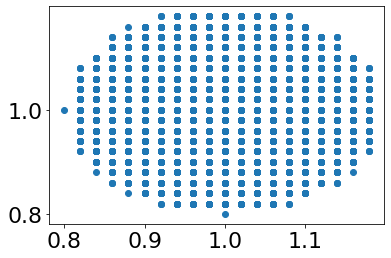

In [34]:
punch_locs=np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.**2)+(H-np.rint(H))**2/(1.**2))<(radius)**2)
known_locs=np.where(((L-np.rint(L))**2/(1.**2)+(K-np.rint(K))**2/(1.**2)+(H-np.rint(H))**2/(1.**2))>=(radius)**2)
total_known_locations = int(np.size(known_locs)/3)
total_unknown_locations = int(np.size(punch_locs)/3) #np.where returns the indices along the x,y, and z directions
#where the above relation holds and np.size gives the total number of indices (x_indices + y_indices + z_indices)
#Hence we need to divide by 3 to get the number of known/unknown locations.

#plotting the punch locs to ensure they are correct! (in 2D)
print(total_unknown_locations)
plt.scatter(K[punch_locs[0], punch_locs[1], punch_locs[2]], H[punch_locs[0], punch_locs[1], punch_locs[2]])

In [19]:
xcoordinate = np.asarray(x[begin_idx + known_locs[0]])
ycoordinate = np.asarray(x2[begin_idx + known_locs[1]])
zcoordinate = np.asarray(x3[begin_idx + known_locs[2]])
known_coordinates =np.asarray([xcoordinate, ycoordinate, zcoordinate])
print(known_coordinates)
xobs = np.reshape(known_coordinates.T, (total_known_locations, 3))
print(xobs)

[[0.8  0.8  0.8  ... 1.22 1.22 1.22]
 [0.8  0.8  0.8  ... 1.22 1.22 1.22]
 [0.8  0.82 0.84 ... 1.18 1.2  1.22]]
[[0.8  0.8  0.8 ]
 [0.8  0.8  0.82]
 [0.8  0.8  0.84]
 ...
 [1.22 1.22 1.18]
 [1.22 1.22 1.2 ]
 [1.22 1.22 1.22]]


In [25]:
yobs = z3d[begin_idx + known_locs[0], begin_idx + known_locs[1], begin_idx + known_locs[2]]
xgrid = np.mgrid[xbegin:xend:complex(idx),xbegin:xend:complex(idx), xbegin:xend:complex(idx) ]
print(np.size(xgrid))
xflat = xgrid.reshape(3, -1).T
starttime = timeit.default_timer()
yflat = RBFInterpolator(xobs, yobs, kernel='linear')(xflat)
ygrid = yflat.reshape(idx, idx, idx)
print("Time taken for SCIPY RBF interpolation for the entire grid approximately:", 
      (timeit.default_timer() - starttime)*216)
# 

31944
Time taken for SCIPY RBF interpolation for the entire grid approximately: 535.0260420720151


[[11.10712  11.046196 10.981495 10.913519]
 [11.046195 10.988783 10.92785  10.863744]
 [10.981495 10.927849 10.870976 10.81109 ]
 [10.913518 10.863744 10.81109  10.75561 ]]
[[11.123738 11.061438 10.995502 10.926282]
 [11.061438 11.002418 10.940092 10.87473 ]
 [10.995502 10.940092 10.881679 10.820461]
 [10.926281 10.87473  10.820461 10.763589]]


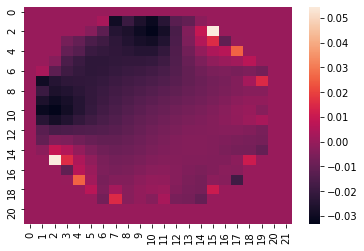

In [22]:
import seaborn as sns
check_idx =11
sns.heatmap(ygrid[check_idx,:,:] - restored_img_full[begin_idx + check_idx,begin_idx+0:begin_idx+idx,begin_idx+0:begin_idx+idx])
print(ygrid[check_idx,8:12,8:12])
print(restored_img_full[begin_idx+check_idx,begin_idx+8:begin_idx+12,begin_idx+8:begin_idx+12])

## Save the Matern and Laplace Interpolated data to an .nxs file 

In [ ]:
expt_data = nxload(save_data_dir + 'movo2_40_120K.nxs')['entry'] # or root['entry/masked_transform']

In [ ]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored[0:311,0:411,0:411]), name='sphere_punch_matern_interp_data')
root.entry.sphere_matern_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_matern_data.nxs')

In [ ]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_restored_laplace[0:311,0:411,0:411]), name='sphere_punch_laplace_interp_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_sphere_laplace_data.nxs')

In [ ]:
root = NXroot(NXentry())
stdinterp = NXfield(symmetrize(z3d_copy[0:311,0:411,0:411]), name='original_data')
root.entry.sphere_laplace_data = NXdata(stdinterp, expt_data.symm_transform[-6.:5.98,-8.:7.98,-8.:7.98].nxaxes)

#root.save(save_data_dir + 'aux/movo2_40_original_data.nxs')